# Motor Imagery: Machine Leaning In-class Exercise

## Step 0: Import neceessary toolboxes

In [58]:
# import require library for preprocess
import mne
import numpy as np
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from mne.datasets import eegbci
import scipy
import pickle
from mne.decoding import CSP

# import require library for classification
from sklearn.svm import SVC # SVM library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA library
from sklearn.neighbors import KNeighborsClassifier # KNN library

from sklearn.metrics import classification_report,confusion_matrix # Result representation
from sklearn.model_selection import train_test_split

## Step 1: Read data file

In [59]:
raw_eeg = mne.io.read_raw_fif("Motor_Imagery.fif")

Opening raw data file Motor_Imagery.fif...
    Range : 0 ... 311249 =      0.000 ...  1244.996 secs
Ready.


C:\Users\pipo_\AppData\Local\Temp\ipykernel_26496\3193620966.py:1: RuntimeWarning: This filename (Motor_Imagery.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_eeg = mne.io.read_raw_fif("Motor_Imagery.fif")


## Step 2: Data preprocessing -- set channel locations/ downsampling/ frequency filtering (bandpass)/ epoching

Note: this data already applies filter 

In [60]:
eeg1= raw_eeg.pick(raw_eeg.ch_names[0:8])

events, event_dict = mne.events_from_annotations(eeg1)

event_dict =  {'OVTK_GDF_Left': 2,
 'OVTK_GDF_Right': 3,
 'OVTK_GDF_Tongue': 4,
 'OVTK_GDF_Up': 5}

arr= np.arange(len(events))
events_1 = np.delete(events, [0], axis= 0)
arr2= np.arange(len(events_1))
events = events_1[(arr2 % 5 == 0)]

Epochs = mne.Epochs(eeg1, events, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 4.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop',
        baseline=(-0.5,0.0)
    )

labels = Epochs.events[:,-1]

Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up']
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 120 events and 1126 original time points ...
0 bad epochs dropped


In [61]:
Epochs

Number of events,120
Events,OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30
Time range,-0.500 – 4.000 s
Baseline,-0.500 – 0.000 s


## 2.5 Raw EEG visualization

No projector specified for this dataset. Please consider the method self.add_proj.


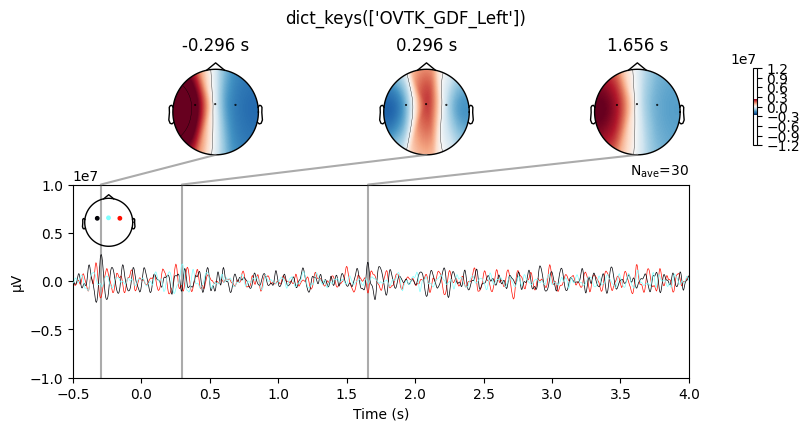

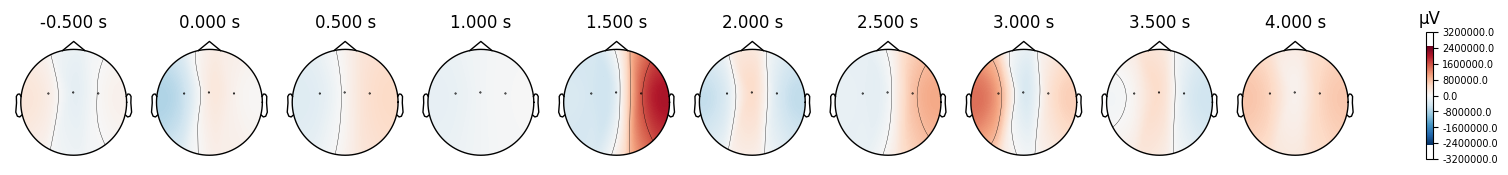

No projector specified for this dataset. Please consider the method self.add_proj.


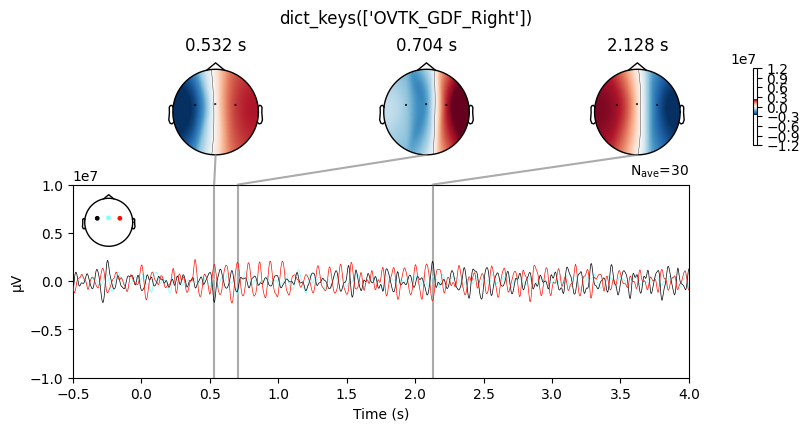

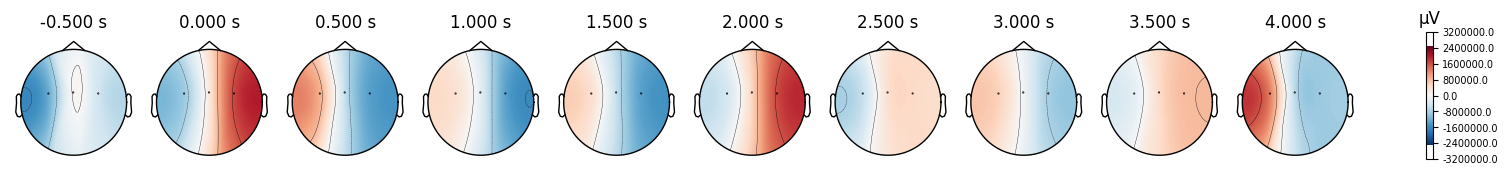

No projector specified for this dataset. Please consider the method self.add_proj.


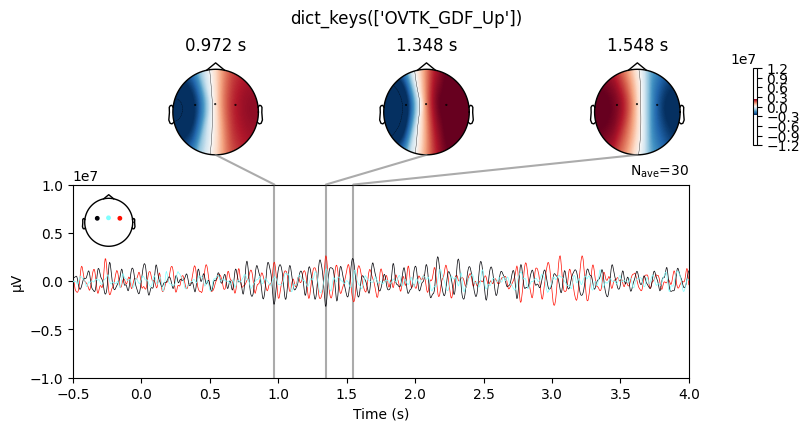

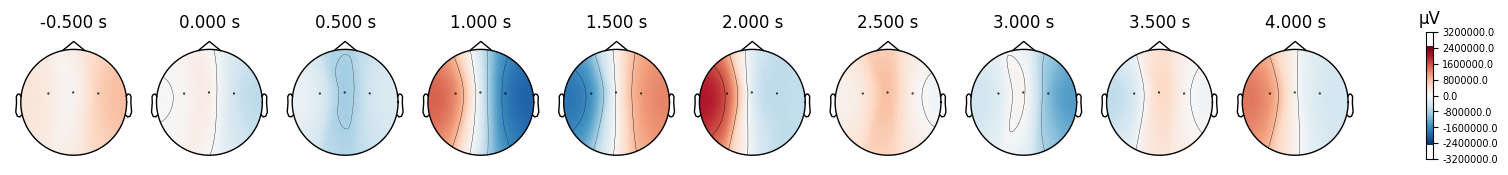

No projector specified for this dataset. Please consider the method self.add_proj.


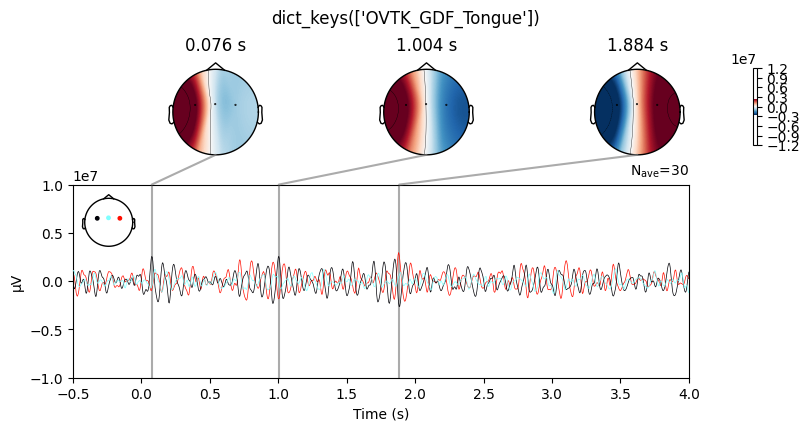

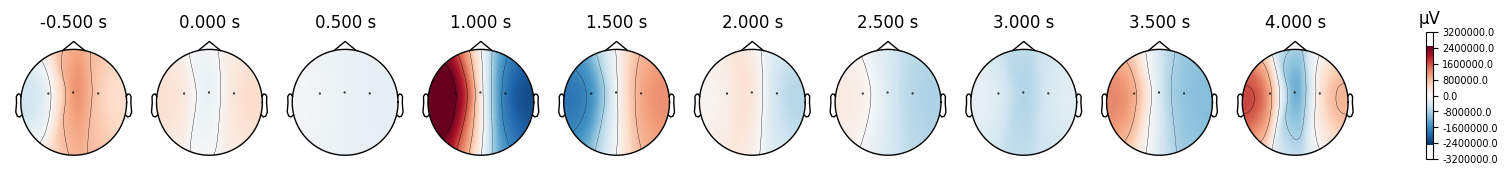

In [62]:
ch_names_MI = ['C3', 'Cz', 'C4']
Left_epoch = Epochs['OVTK_GDF_Left']
Right_epoch = Epochs['OVTK_GDF_Right']
Feet_epoch = Epochs['OVTK_GDF_Up']
Nonim_epoch = Epochs['OVTK_GDF_Tongue']

Classes_epoch = [Left_epoch, Right_epoch, Feet_epoch, Nonim_epoch]
time = np.arange(-0.5, 4 + 0.1, 0.5)
for i in range(len(Classes_epoch)):
    select_ch = Classes_epoch[i].copy()
    select_ch.pick(ch_names_MI).average().plot_joint(picks=ch_names_MI, title= str(Classes_epoch[i].event_id.keys()), ts_args={"ylim": dict(eeg=[-10e6, 10e6])}, topomap_args = {"vlim" :[-2.5e6, 2.5e6]})
    select_ch.pick(ch_names_MI).average().plot_topomap(times=time, ch_type="eeg", vlim=[-2.5e6, 2.5e6])


## Split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Epochs.get_data(), labels, test_size= 0.3, random_state = 0, stratify=labels) 
#split data with counter balance

## Step3: Feature extraction

## 3.1 Common Spatial Pattern

Computing rank from data with rank=None
    Using tolerance 1.6 (2.2e-16 eps * 8 dim * 9.2e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 8 dim * 9.5e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 8 dim * 1.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 8 dim * 1.1e+15  max singular value)
    Estimated rank (mag): 8
    MAG

C:\Users\pipo_\AppData\Local\Temp\ipykernel_26496\1239005763.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train, X_test, y_train, y_test = train_test_split(Epochs.get_data(), labels, test_size= 0.3, random_state = 0, stratify=labels)


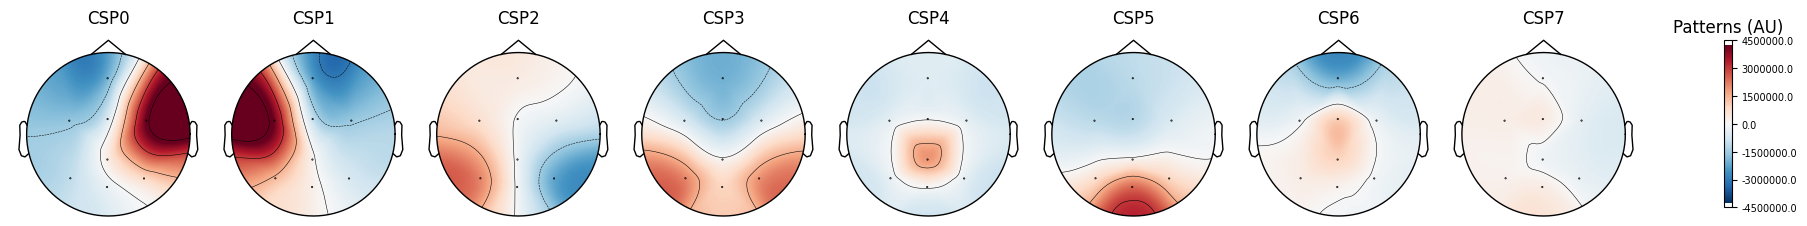

...


In [63]:
csp = CSP(n_components=8, reg=None, log=True)
csp.fit(X_train, y_train)

csp.plot_patterns(Epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)
print("...")

## Step 4: Classification

In [64]:
#apply CSP
X_train = csp.transform(X_train)
X_test = csp.transform(X_test)

print(X_train.shape)

(84, 8)


# <span style="color:orange">Mini Assignment</span>
- Try to apply LDA, SVM and KNN for predict X_test data and show accuracy report 